# Data Cleaning

In [1]:
# read the csv data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

products = pd.read_csv('product_table.csv')
transactions = pd.read_csv('transaction_table.csv')

## Following same data cleaning as in Project 1

In [2]:
#To fix this, we will create our own transaction ID (Grouping by customer, store and date)
temp = transactions.groupby(['cust_id', 'tran_dt', 'store_id']).size().reset_index().rename(columns = {0:'trans_id'})
temp['trans_id'] = temp.index
print(temp.iloc[0:10, ])

# Next we perform a join to get this id column into the transactions df
transactions = transactions.set_index(['cust_id', 'tran_dt','store_id']).join(temp.set_index(['cust_id', 'tran_dt','store_id']))

   cust_id     tran_dt  store_id  trans_id
0    29568  2016-03-01       192         0
1    29568  2016-03-03       192         1
2    29568  2016-03-04       192         2
3    29568  2016-03-09       192         3
4    29568  2016-03-11       192         4
5    29568  2016-03-12       192         5
6    29568  2016-04-02       192         6
7    29568  2016-04-03       192         7
8    29568  2016-04-05       192         8
9    29568  2016-04-07       192         9


In [3]:
# Here, we drop the old ID column, and reorder the columns
transactions = transactions.reset_index()
transactions = transactions.drop('tran_id', axis = 1)
cols = list(transactions.columns.values)
print(cols)
newcols = ['cust_id', 'trans_id', 'tran_dt', 'store_id', 'prod_id', 'prod_unit', 
           'tran_prod_sale_amt', 'tran_prod_sale_qty', 
           'tran_prod_discount_amt', 'tran_prod_offer_cts', 'tran_prod_paid_amt', 'prod_unit_price']
transactions = transactions[newcols]

['cust_id', 'tran_dt', 'store_id', 'prod_id', 'prod_unit', 'tran_prod_sale_amt', 'tran_prod_sale_qty', 'tran_prod_discount_amt', 'tran_prod_offer_cts', 'tran_prod_paid_amt', 'prod_unit_price', 'trans_id']


In [4]:
# We are going to keep the $0.00 transactions but get rid of the negative instances
transactions = transactions[transactions['tran_prod_paid_amt']>=0]

In [5]:
#Let's merge both df's to create a complete one
complete_df = pd.merge(transactions,products,left_on = 'prod_id', right_on = 'prod_id', how = 'left') #.drop('prod_id', axis = 1)
print(len(transactions), ', ', len(complete_df))

29617577 ,  29617577


In [6]:
# Get rid of the transaction records of bags
complete_df=complete_df[complete_df["category_desc_eng"]!="BAGS"]
complete_df.shape

(28763154, 18)

In [338]:
# try to find the cost margin info
v_cat_group = complete_df.groupby(['category_desc_eng'])['tran_prod_sale_qty'].agg('sum').sort_values(ascending = False)
print('\n top 5 categories with most volume: \n', v_cat_group.head())

#function to calculate where each categories lies in a quartile of a distribution of the different volumes

def volume_quantile(x):
    if x <= v_cat_group.quantile(.25):
        return '1'
    elif x <= v_cat_group.quantile(.5):
        return'2'
    elif x <= v_cat_group.quantile(.75):
        return '3'
    else: 
        return '4'
    
#added the quartile classification into a df

Vol_Q = [volume_quantile(x) for x in v_cat_group]
print(Vol_Q)

cat_vol = list(zip(v_cat_group,Vol_Q))
cat_vol_df = pd.DataFrame(cat_vol, columns = [ 'volume','vol_q'] , index =v_cat_group.index)

#merged the recently create df from above to the original completed df

complete_df_cost = pd.merge(complete_df,cat_vol_df,left_on = 'category_desc_eng', right_on = 'category_desc_eng', how = 'inner')
complete_df_cost.head(100)

#to calculate profits

def profit_calculations(x):
    x=int(x)
    re =  (x-1)*(x-2)*(x-3)*0.4/6 - (x-1)*(x-2)*(x-4)*0.25/2 + (x-1)*(x-3)*(x-4)*0.15/2 - (x-2)*(x-3)*(x-4)*0.05/6
    return re

complete_df_cost['profit_margin'] = [profit_calculations(x) for x in complete_df.vol_q]
complete_df_cost["cost_margin"] = 1 - complete_df_cost["profit_margin"]
cost_info = complete_df_cost[['prod_id', 'cost_margin']]
cost_info = cost_info.groupby('prod_id').agg({'cost_margin':'mean'})


 top 5 categories with most volume: 
 category_desc_eng
PAO MANUFACTURE     2206696.875
MINERAL WATERS      2171751.000
FRESH UHT MILK      1774026.000
YOGURT HEALTH       1491115.000
SPECIAL UHT MILK    1317446.000
Name: tran_prod_sale_qty, dtype: float64
['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '

AttributeError: 'DataFrame' object has no attribute 'vol_q'

## Demension Reduction - Reduce the number of stores/categories/products we should consider

Only consider the stores and categoreis that generate most revenues, and only consdier products that have been sold on 04/13/2017 - 04/19/2017

### Store

In [7]:
# get a table see each store's total sales in 2016&2017, and sort it by total sales
store_info=complete_df.groupby(['store_id']).agg({'tran_prod_paid_amt':'sum'}).reset_index().sort_values(by='tran_prod_paid_amt',ascending=False)

In [8]:
# Calculate the percentage of each store's sales in total sales
store_info['percentage']=store_info['tran_prod_paid_amt']/store_info['tran_prod_paid_amt'].sum()
store_info['accumulated_percentage']=store_info['percentage'].cumsum()

In [9]:
store_info.head()

,store_id,tran_prod_paid_amt,percentage,accumulated_percentage
163,342,783901.509999,0.012633,0.012633
166,345,717209.260000,0.011558,0.024191
170,349,678869.180000,0.010940,0.035131
165,344,623659.720000,0.010051,0.045182
164,343,590740.670000,0.009520,0.054702


In [10]:
# Check on the result
store_info['percentage'].sum()

1.0

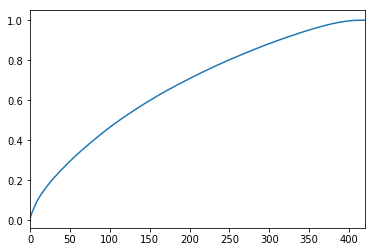

In [11]:
# Use plot to see how many stores cover 25% sales
store_info_plot=store_info.reset_index()
store_info_plot['accumulated_percentage'].plot(kind='line')

In [12]:
# Pick up the first 40 stores will cover 25% total revenues
store_info.iloc[0:40,2].sum()

0.2516168050476272

In [13]:
# Get the 40 store id we will consider in later stages
store_id=store_info.iloc[0:40,0]

### Category

In [14]:
# get a table see each category's total sales in 2016&2017, and sort it by total sales
category_info=complete_df.groupby(['category_id']).agg({'tran_prod_paid_amt':'sum','category_desc_eng':'min'}).reset_index().sort_values(by='tran_prod_paid_amt',ascending=False)

In [15]:
# Calculate the percentage of each category's sales in total sales
category_info['percentage']=category_info['tran_prod_paid_amt']/category_info['tran_prod_paid_amt'].sum()

In [16]:
category_info.head()

,category_id,tran_prod_paid_amt,category_desc_eng,percentage
310,95890.0,2.483963e+06,FRESH PORK,0.040031
314,95894.0,2.401663e+06,FRESH BEEF,0.038705
308,95888.0,2.379408e+06,FRESH POULTRY MEAT,0.038346
370,95971.0,1.344207e+06,DRY SALT COD,0.021663
247,95797.0,1.296609e+06,FINE WINES,0.020896


In [17]:
# Check on the result
category_info['percentage'].sum()

0.9999999999999997

In [18]:
# Since we don't consider fresh products, we should get rid of several categories
t1=category_info
category_info_new = t1.drop([t1.index[0] , t1.index[1], t1.index[2], t1.index[6], t1.index[8], t1.index[13], t1.index[17], t1.index[21],t1.index[23], t1.index[24], t1.index[25], t1.index[27], t1.index[28]])
# Calculate accumulated percentage
category_info_new['accumulated_percentage']=category_info_new['percentage'].cumsum()

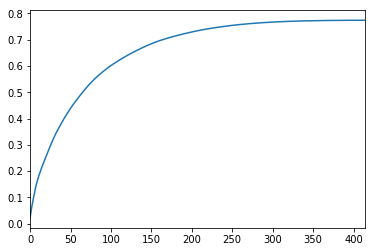

In [19]:
# Use plot to see how many categories cover 25% sales
category_info_plot=category_info_new.reset_index()
category_info_plot['accumulated_percentage'].plot(kind='line')

In [20]:
category_info_new.head(5)

,category_id,tran_prod_paid_amt,category_desc_eng,percentage,accumulated_percentage
370,95971.0,1.344207e+06,DRY SALT COD,0.021663,0.021663
247,95797.0,1.296609e+06,FINE WINES,0.020896,0.042559
419,96026.0,1.191705e+06,COFFEES AND ROASTED MIXTURES,0.019205,0.061765
250,95800.0,1.057406e+06,BEER WITH ALCOHOL,0.017041,0.078806
373,95974.0,9.889713e+05,FROZEN FISH SERVICE,0.015938,0.094744


In [21]:
# Pick up the first 20 categories will cover 25% total revenues
category_info_new.iloc[0:20,3].sum()

0.24978864536771947

In [22]:
# Get the 40 store id we will consider in later stages
category_id=category_info_new.iloc[0:20,0]

### Products

In [23]:
df_one_week=complete_df[complete_df["tran_dt"]>="2017-04-13"][complete_df["tran_dt"]<="2017-04-19" ]

C:\Users\maysh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [24]:
# Check on results
df_one_week['tran_dt'].unique()

array(['2017-04-13', '2017-04-15', '2017-04-19', '2017-04-14',
       '2017-04-18', '2017-04-16', '2017-04-17'], dtype=object)

In [25]:
# Use 20 category id to find the product list we will investigate on later
prod_id=df_one_week[df_one_week["category_id"].isin(category_id)]["prod_id"]
prod_id.head()

2632    999176043
2634    999187317
2637    999242512
2646    999515048
2648    999742491
Name: prod_id, dtype: int64

In [26]:
# We have 1712 products to consider in next stage
prod_id.nunique()

1712

## Train set - Prepare historical data in order to find response function in Step 2

### Make necessary calculation

In [27]:
# Calculate price
complete_df["pocket_price"]=round(complete_df["tran_prod_paid_amt"]/complete_df["tran_prod_sale_qty"],2)
complete_df["list_price"]=round(complete_df["prod_unit_price"],2)
complete_df.tail()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng,pocket_price,list_price
29617572,99999776,2830562,2017-12-30,194,999891074,CT,1.89,1.000,0.00,0,1.89,1.890000,94769.0,DROPS BALSAMICOS LIN,95089.0,DROPS BALSAMICOS,DR BAYARD,BALSAMIC DROPS,1.89,1.89
29617573,99999776,2830562,2017-12-30,194,999953483,KG,1.78,1.054,-0.63,1,1.15,1.688805,94459.0,PERA ROCHA,95940.0,PERA,FRUTAS&VEGETAIS,WAIT,1.09,1.69
29617574,99999776,2830563,2017-12-31,194,999679870,KG,8.69,1.024,0.00,0,8.69,8.486328,90671.0,COROA FRUTOS SECOS,95965.0,BOLOS SAZONAIS,NO LABEL,SEASONAL CAKES,8.49,8.49
29617575,99999776,2830563,2017-12-31,194,999680246,CT,0.51,3.000,0.00,0,0.51,0.170000,90724.0,PADAS,95072.0,PAO FABRICO,NO LABEL,PAO MANUFACTURE,0.17,0.17
29617576,99999776,2830563,2017-12-31,194,999953443,KG,1.74,0.872,0.00,0,1.74,1.995413,90634.0,PEQUENOS CITRINOS,95954.0,CITRINOS,FRUTAS&VEGETAIS,CITRUS,2.00,2.00


In [28]:
# Get seasonality & month data
complete_df['season'] = complete_df['tran_dt'].str.slice(start=5, stop=7)
complete_df['month'] = complete_df['tran_dt'].str.slice(start=0, stop=7)
complete_df.tail()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,...,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng,pocket_price,list_price,season,month
29617572,99999776,2830562,2017-12-30,194,999891074,CT,1.89,1.000,0.00,0,...,94769.0,DROPS BALSAMICOS LIN,95089.0,DROPS BALSAMICOS,DR BAYARD,BALSAMIC DROPS,1.89,1.89,12,2017-12
29617573,99999776,2830562,2017-12-30,194,999953483,KG,1.78,1.054,-0.63,1,...,94459.0,PERA ROCHA,95940.0,PERA,FRUTAS&VEGETAIS,WAIT,1.09,1.69,12,2017-12
29617574,99999776,2830563,2017-12-31,194,999679870,KG,8.69,1.024,0.00,0,...,90671.0,COROA FRUTOS SECOS,95965.0,BOLOS SAZONAIS,NO LABEL,SEASONAL CAKES,8.49,8.49,12,2017-12
29617575,99999776,2830563,2017-12-31,194,999680246,CT,0.51,3.000,0.00,0,...,90724.0,PADAS,95072.0,PAO FABRICO,NO LABEL,PAO MANUFACTURE,0.17,0.17,12,2017-12
29617576,99999776,2830563,2017-12-31,194,999953443,KG,1.74,0.872,0.00,0,...,90634.0,PEQUENOS CITRINOS,95954.0,CITRINOS,FRUTAS&VEGETAIS,CITRUS,2.00,2.00,12,2017-12


### Use filter we created in Step 1.2 to get rid of unnecessary products / stores

In [29]:
clean_df=complete_df[complete_df["prod_id"].isin(prod_id)]
clean_df=clean_df[clean_df["store_id"].isin(store_id)]

In [31]:
# Check on results
print("Stores:",clean_df["store_id"].nunique(),"Products:",clean_df["prod_id"].nunique())

Stores: 40 Products: 1712


### Demand & List_Price & Pocket_Price 

In [32]:
#df shows the how much each store sells each product at a particular combination of list_price and pocket_price in each month
df=clean_df.groupby(['month','prod_id','store_id','list_price','pocket_price']).agg({'tran_prod_sale_qty':'sum','season':'min'}).reset_index()
df.head()

,month,prod_id,store_id,list_price,pocket_price,tran_prod_sale_qty,season
0,2016-01,184808010,157,2.69,1.79,7.0,01
1,2016-01,184808010,182,2.69,1.79,1.0,01
2,2016-01,184808010,311,2.69,1.79,1.0,01
3,2016-01,184808010,315,2.69,1.79,1.0,01
4,2016-01,184808010,331,2.69,1.79,2.0,01


### Get the info of substitutes

In [34]:
# Use complete_df instead of clean_df since we need to consider all products as possible substitutes
complete_df['median_sub'] = complete_df.groupby(['category_id', 'month', 'store_id'])['pocket_price'].transform(np.median)
complete_df['min_sub'] = complete_df.groupby(['category_id', 'month', 'store_id'])['pocket_price'].transform(min)

In [36]:
# Get a table only contain info for substitutes
df_sub_cols=["month","prod_id","store_id","category_id","median_sub","min_sub"]
df_sub=complete_df[df_sub_cols]
df_sub.head()

,month,prod_id,store_id,category_id,median_sub,min_sub
0,2016-03,230909010,192,95858.0,0.22,0.16
1,2016-03,266417009,192,95854.0,0.34,0.25
2,2016-03,486635012,192,95854.0,0.34,0.25
3,2016-03,999194957,192,95853.0,0.99,0.49
4,2016-03,999227294,192,95855.0,0.99,0.45


### Get the info of complements

In [ ]:
# Get the transaction record of all products
tran_prod = complete_df[['trans_id','prod_id']]

In [40]:
# Find the complement of each product, which is the most frequent bought product together with the product we investigate on 
df_com = pd.DataFrame(columns=['prod_id', 'complement_id'])
for specific_prod_id in prod_id:
    df_prod = tran_prod[tran_prod['prod_id'] == specific_prod_id]
    trans = df_prod['trans_id'].unique()
    df_tran = tran_prod[tran_prod['trans_id'].isin(trans)]
    prod_counts = df_tran['prod_id'].value_counts()
    complement = prod_counts.index[1]
    df_com = df_coms.append({'prod_id': specific_prod_id, 'complement_id': complement}, ignore_index=True)

In [41]:
# Check Results
df_com.shape

(1712, 2)

In [42]:
df_com.head()

,prod_id,complement_id
0,266012011,999956795
1,999276934,999956795
2,999401500,999956795
3,999514712,999956795
4,999233757,999444532


In [ ]:
df_com.to_csv('Project_3_Complements.csv')

In [45]:
# After finding the complement of each product, find the price info of complements

# Get a list of complements id
complement_id=df_com.iloc[:,1]

clean_df_com=complete_df[complete_df["prod_id"].isin(complement_id)]
clean_df_com=clean_df_com[clean_df_com["store_id"].isin(store_id)]

In [46]:
df_whole=clean_df_com.groupby(['month','prod_id','store_id']).agg({'list_price':'mean','pocket_price':'mean'}).reset_index()
df_whole.head()

,month,prod_id,store_id,list_price,pocket_price
0,2016-01,299262011,341,0.99,0.99
1,2016-01,299262011,344,0.99,0.99
2,2016-01,299262011,348,0.99,0.99
3,2016-01,299262011,395,0.99,0.99
4,2016-01,299262011,505,0.99,0.99


In [47]:
df_whole = df_whole.rename(columns = {"prod_id":"complement_id"}) 
df_whole = df_whole.rename(columns = {"pocket_price":"complement_price"}) 
df_whole = df_whole.drop("list_price",axis=1)

In [48]:
df_whole.head()

,month,complement_id,store_id,complement_price
0,2016-01,299262011,341,0.99
1,2016-01,299262011,344,0.99
2,2016-01,299262011,348,0.99
3,2016-01,299262011,395,0.99
4,2016-01,299262011,505,0.99


In [49]:
df_com=df_whole.merge(df_com,on='complement_id')
df_com.head()

,month,complement_id,store_id,complement_price,prod_id
0,2016-01,299262011,341,0.99,299262012
1,2016-01,299262011,344,0.99,299262012
2,2016-01,299262011,348,0.99,299262012
3,2016-01,299262011,395,0.99,299262012
4,2016-01,299262011,505,0.99,299262012


In [50]:
# Revise complement_price
df_com['complement_price']=round(df_com['complement_price'],2)

### Merge info of product, substitute, complement together

In [52]:
# Get info of substitutes
df1=pd.merge(df,df_sub,how="inner",left_on=["month","prod_id","store_id"],right_on=["month","prod_id","store_id"]).drop_duplicates()
df1.head()

,month,prod_id,store_id,list_price,pocket_price,tran_prod_sale_qty,season,category_id,median_sub,min_sub
0,2016-01,184808010,157,2.69,1.79,7.0,01,95856.0,1.535,0.36
4,2016-01,184808010,182,2.69,1.79,1.0,01,95856.0,1.690,0.24
5,2016-01,184808010,311,2.69,1.79,1.0,01,95856.0,1.690,0.49
6,2016-01,184808010,315,2.69,1.79,1.0,01,95856.0,1.675,0.24
7,2016-01,184808010,331,2.69,1.79,2.0,01,95856.0,1.415,0.24


In [53]:
# Get info of complements
df1=pd.merge(df1,df_com,how="inner",left_on=["month","prod_id","store_id"],right_on=["month","prod_id","store_id"]).drop_duplicates()

In [54]:
df1.head()

,month,prod_id,store_id,list_price,pocket_price,tran_prod_sale_qty,season,category_id,median_sub,min_sub,complement_id,complement_price
0,2016-01,184808010,157,2.69,1.79,7.0,01,95856.0,1.535,0.36,999956795,1.04
1,2016-01,184808010,182,2.69,1.79,1.0,01,95856.0,1.690,0.24,999956795,1.06
2,2016-01,184808010,311,2.69,1.79,1.0,01,95856.0,1.690,0.49,999956795,1.04
3,2016-01,184808010,315,2.69,1.79,1.0,01,95856.0,1.675,0.24,999956795,1.05
4,2016-01,184808010,331,2.69,1.79,2.0,01,95856.0,1.415,0.24,999956795,1.04


In [55]:
# Check on results
print("Stores:",df1["store_id"].nunique(),"Products:",df1["prod_id"].nunique())

Stores: 40 Products: 1712


In [59]:
# export first dataframe, which contains historical information of price & demand, 
# and we will find the response function according to df1
df1.to_csv("df1.csv")

In [150]:
df1.isnull().sum()

month                 0
prod_id               0
store_id              0
list_price            0
pocket_price          0
tran_prod_sale_qty    0
season                0
category_id           0
median_sub            0
min_sub               0
complement_id         0
complement_price      0
dtype: int64

## Test set - Prepare a dataframe to make predictions and optimization

### Prepare info of product, substitutes, complements in that week

In [303]:
# Prepare basic info in that week
df_one_week["pocket_price"]=round(df_one_week["tran_prod_paid_amt"]/df_one_week["tran_prod_sale_qty"],2)
df_one_week["list_price"]=round(df_one_week["prod_unit_price"],2)
# Get seasonality & month data
df_one_week['season'] = df_one_week['tran_dt'].str.slice(start=5, stop=7)
df_one_week['month'] = df_one_week['tran_dt'].str.slice(start=0, stop=7)

In [305]:
# Get sub
df_one_week['median_sub'] = df_one_week.groupby(['category_id', 'month', 'store_id'])['pocket_price'].transform(np.median)
df_one_week['min_sub'] = df_one_week.groupby(['category_id', 'month', 'store_id'])['pocket_price'].transform(min)

In [301]:
# Get info of complements in that week
df_one_week_com_new = clean_df_com[clean_df_com["tran_dt"]>="2017-04-13"][clean_df_com["tran_dt"]<="2017-04-19" ]
df_com_new = df_one_week_com_new.groupby(['prod_id','store_id']).agg({'pocket_price':'mean'}).reset_index()
df_com_new = df_com_new.rename(columns = {"prod_id":"complement_id", "pocket_price":"complement_price"})
df_com_new['complement_price']=round(df_com_new['complement_price'],2)

In [173]:
# Get info of list price, pocket price, sub price in that week
df2 = df_one_week.groupby(['prod_id','store_id']).agg({'list_price':'mean','pocket_price':'mean','median_sub':'mean','min_sub':'mean','tran_prod_sale_qty':'sum'}).reset_index()
df2.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,tran_prod_sale_qty
0,156953010,157,2.69,2.69,1.79,0.4,1.0
1,156953010,308,2.69,2.69,2.69,0.4,1.0
2,156953010,335,2.69,2.69,1.79,0.4,1.0
3,156953010,341,2.69,2.69,1.69,0.4,1.0
4,156953010,343,2.69,2.69,2.69,0.4,1.0


In [175]:
# Get info of complements in that week
df_com_pure = df_com.copy()
df2 = df2.merge(df_com_pure, how='left', left_on = ['prod_id'], right_on = ['prod_id'])
df2 = df2.merge(df_com_new, how='left', left_on = ['complement_id','store_id'], right_on = ['complement_id','store_id'])

### Make necessary calculation

In [174]:
# Calculate the promotion
df2['promotion'] = 1-df2['pocket_price']/df2['list_price']

#rename demand
df2 = df2.rename(columns = {"tran_prod_sale_qty":"original_demand"}) 
df2.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,original_demand,promotion
0,156953010,157,2.69,2.69,1.79,0.4,1.0,0.0
1,156953010,308,2.69,2.69,2.69,0.4,1.0,0.0
2,156953010,335,2.69,2.69,1.79,0.4,1.0,0.0
3,156953010,341,2.69,2.69,1.69,0.4,1.0,0.0
4,156953010,343,2.69,2.69,2.69,0.4,1.0,0.0


In [177]:
# Define unique id for combination of product & store
df2['prod_store_id'] = 1000*df2['prod_id']+df2['store_id']
April_week_prod_store_id = df2['prod_store_id']

In [178]:
# Reorder columns in df2 (test data)
df2 = df2[['prod_id', 'store_id', 'list_price', 'pocket_price', 'median_sub', 'min_sub', 'complement_id', 'complement_price', 'original_demand', 'promotion', 'prod_store_id']]
df2.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,prod_store_id
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,156953010157
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,156953010308
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,156953010335
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,156953010341
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,156953010343


### Get the info of April, in case the product wasn't sold in the store in that week

In [311]:
df1_04 = df1[(df1['month']=='2017-04') | (df1['month']=='2016-04')]

In [312]:
df2_04 = df1_04.groupby(['prod_id','store_id']).agg({'list_price':'mean',
                                                       'pocket_price':'mean',
                                                       'median_sub':'mean',
                                                       'min_sub':'min', 
                                                       'complement_id':'min', 
                                                       'complement_price':'min'})

In [181]:
df2_04 = df2_04.reset_index()
df2_04['original_demand']=0
df2_04['promotion'] = 1-df2_04['pocket_price']/df2_04['list_price']
df2_04['prod_store_id'] = 1000*df2_04['prod_id']+df2_04['store_id']
April_prod_store_id = df2_04['prod_store_id']
df2_04.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,prod_store_id
0,156953010,157,2.24,2.24,1.79,0.4,999956795,1.05,0,0.0,156953010157
1,156953010,192,2.69,2.69,1.49,0.4,999956795,1.04,0,0.0,156953010192
2,156953010,308,2.69,2.69,2.69,0.4,999956795,1.04,0,0.0,156953010308
3,156953010,315,1.79,1.79,2.34,0.4,999956795,1.05,0,0.0,156953010315
4,156953010,320,2.24,2.24,1.49,0.4,999956795,1.05,0,0.0,156953010320


In [182]:
df2_04.shape

(27663, 11)

In [183]:
df2_04 = df2_04[~df2_04['prod_store_id'].isin(April_week_prod_store_id)]
df2_04.shape

(20003, 11)

### Create a dataframe to compile all info together (single week data, April data, 2-year data)

In [316]:
df2_all = df1.groupby(['prod_id','store_id']).agg({'list_price':'mean',
                                                       'pocket_price':'mean',
                                                       'median_sub':'mean',
                                                       'min_sub':'min', 
                                                       'complement_id':'min', 
                                                       'complement_price':'min'})

In [185]:
df2_all = df2_all.reset_index()
df2_all['original_demand']=0
df2_all['promotion'] = 1-df2_all['pocket_price']/df2_all['list_price']
df2_all['prod_store_id'] = 1000*df2_all['prod_id']+df2_all['store_id']
df2_all.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,prod_store_id
0,156953010,151,2.540,1.708889,1.472222,0.00,999956795,0.91,0,0.327209,156953010151
1,156953010,157,2.465,1.930000,1.588750,0.25,999956795,0.90,0,0.217039,156953010157
2,156953010,182,2.690,2.240000,1.815000,0.34,999956795,0.91,0,0.167286,156953010182
3,156953010,192,2.690,2.240000,1.505000,0.29,999956795,0.97,0,0.167286,156953010192
4,156953010,307,2.465,1.693333,1.698333,0.29,999956795,0.91,0,0.313049,156953010307


In [186]:
# Check the results
df2_all.shape

(53663, 11)

In [187]:
# df2_all contains info based on historical data
df2_all = df2_all[~df2_all['prod_store_id'].isin(April_prod_store_id)]
df2_all = df2_all[~df2_all['prod_store_id'].isin(April_week_prod_store_id)]
df2_all.shape

(25968, 11)

In [191]:
whole_prod_store_id=1000*df1['prod_id']+df1['store_id']
df2 = df2[df2['prod_store_id'].isin(whole_prod_store_id)]
df2.shape

(7692, 11)

In [190]:
# Check on results
df2.shape[0]+df2_04.shape[0]+df2_all.shape[0]

53663

In [192]:
# Get the final test data
df2_final = pd.concat([df2,df2_04,df2_all], ignore_index = True)
df2_final.shape

(53663, 11)

In [193]:
df2_final.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,prod_store_id
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,156953010157
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,156953010308
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,156953010335
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,156953010341
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,156953010343


In [197]:
df2_final = df2_final.fillna(0)
df2_final.describe()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,prod_store_id
count,5.366300e+04,53663.000000,53663.000000,53663.000000,53663.000000,53663.000000,5.366300e+04,53663.000000,53663.000000,53663.000000,5.366300e+04
mean,9.176438e+08,398.876451,3.625650,2.916924,2.222933,0.842645,9.987503e+08,0.974055,0.612243,0.147371,9.176438e+11
std,2.343617e+08,144.943982,4.169542,3.228116,2.181382,0.851430,2.845437e+07,0.217431,4.750010,0.181410,2.343617e+11
min,1.569530e+08,151.000000,0.085000,0.000000,0.116667,0.000000,1.787200e+08,0.000000,0.000000,-0.011628,1.569530e+11
25%,9.991777e+08,320.000000,1.340000,1.090000,0.940000,0.280000,9.999568e+08,0.910000,0.000000,0.000000,9.991777e+11
50%,9.992464e+08,346.000000,2.383571,1.950000,1.750000,0.640000,9.999568e+08,0.970000,0.000000,0.037736,9.992464e+11
75%,9.993666e+08,556.000000,3.990000,3.420000,2.623833,0.990000,9.999568e+08,1.040000,0.000000,0.263430,9.993666e+11
max,9.999992e+08,996.000000,54.990000,54.990000,16.990000,9.990000,9.999852e+08,9.990000,431.000000,1.000000,9.999992e+11


In [198]:
df2_final.to_csv("df2_final.csv")

# Find Response Function for combo of Product & Store

In [218]:
# Define RMSE
from sklearn.metrics import mean_squared_error 
from math import sqrt

def RMSE(a,b):
    return sqrt(mean_squared_error(a,b))

In [240]:
# Get season into dummy variable
df1_dummies=pd.get_dummies(data=df1,columns=["season"])
pd.options.display.max_columns = None # this allows us to see all columns for head
df1_dummies.head()

,month,prod_id,store_id,list_price,pocket_price,tran_prod_sale_qty,category_id,median_sub,min_sub,complement_id,complement_price,season_01,season_02,season_03,season_04,season_05,season_06,season_07,season_08,season_09,season_10,season_11,season_12
0,2016-01,184808010,157,2.69,1.79,7.0,95856.0,1.535,0.36,999956795,1.04,1,0,0,0,0,0,0,0,0,0,0,0
1,2016-01,184808010,182,2.69,1.79,1.0,95856.0,1.690,0.24,999956795,1.06,1,0,0,0,0,0,0,0,0,0,0,0
2,2016-01,184808010,311,2.69,1.79,1.0,95856.0,1.690,0.49,999956795,1.04,1,0,0,0,0,0,0,0,0,0,0,0
3,2016-01,184808010,315,2.69,1.79,1.0,95856.0,1.675,0.24,999956795,1.05,1,0,0,0,0,0,0,0,0,0,0,0
4,2016-01,184808010,331,2.69,1.79,2.0,95856.0,1.415,0.24,999956795,1.04,1,0,0,0,0,0,0,0,0,0,0,0


In [177]:
# Define Features
X_columns=["list_price","pocket_price","median_sub","min_sub","complement_price",
          "season_01","season_02","season_03","season_04","season_05","season_06",
          "season_07","season_08","season_09","season_10","season_11","season_12"]

In [178]:
# set combo of prod_id & store_id list
df1_uid=df1[["prod_id","store_id"]].drop_duplicates().reset_index().drop(["index"],axis=1)
df1_uid.head()

,prod_id,store_id
0,184808010,157
1,184808010,182
2,184808010,311
3,184808010,315
4,184808010,331


## Linear Regression + No Transformation

In [216]:
# Create a table called df1_coef to store info of RMSE & intercept
df1_coef=df1_uid
df1_coef=pd.concat([df1_coef,pd.DataFrame(columns=["RMSE",'intercept'])],sort=False)
df1_coef.head()

,prod_id,store_id,RMSE,intercept
0,184808010.0,157.0,NaN,NaN
1,184808010.0,182.0,NaN,NaN
2,184808010.0,311.0,NaN,NaN
3,184808010.0,315.0,NaN,NaN
4,184808010.0,331.0,NaN,NaN


In [219]:
# Use for loops to find the response function for each combo of product & store

import warnings
warnings.filterwarnings('ignore')

dict_coef={}

from sklearn.linear_model import LinearRegression
lr=LinearRegression()
for i in df1_uid.index:
    DF=df1_dummies[df1_dummies["prod_id"]==df1_uid['prod_id'][df1_uid.index[i]]]
    DF=DF[DF["store_id"]==df1_uid['store_id'][df1_uid.index[i]]] # filter according to prod_id & store_id
    
    #Define X & y, and fit linear regression on it
    X=DF[X_columns]
    y=DF["tran_prod_sale_qty"]
    lr.fit(X, y)
    
    #Calculate RMSE
    lr_pred_test=lr.predict(X)
    df1_coef['RMSE'][i]=RMSE(y,lr_pred_test)
    
    df1_coef['intercept'][i]=lr.intercept_
    
    # Save coefficients in a dictionary
    dict_coef.update({i:lr.coef_})


In [220]:
# Check on elapsed time
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2020-04-06 00:05:43


In [222]:
# Transform the dictionary of coefficients info into dataframe
df1_coef2=pd.DataFrame.from_dict(dict_coef, orient='index')
df1_coef2.columns=["b_list_price","b_pocket_price","b_median_sub","b_min_sub","b_complement_price",
          "b_season_01","b_season_02","b_season_03","b_season_04","b_season_05","b_season_06",
          "b_season_07","b_season_08","b_season_09","b_season_10","b_season_11","b_season_12"]
df1_coef2.head()

,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_01,b_season_02,b_season_03,b_season_04,b_season_05,b_season_06,b_season_07,b_season_08,b_season_09,b_season_10,b_season_11,b_season_12
0,1.883096,-0.073079,0.582795,2.077828,26.096159,1.627603,-0.891482,3.019920e+00,-1.228205,-0.255251,0.180766,0.660014,0.291747,-0.559877,-1.553691e+00,-0.137017,-1.154527
1,3.951305,-3.895154,19.473222,41.076643,5.688182,-2.033360,5.480687,-6.705747e-14,5.127492,-1.058783,-0.688400,-0.209269,-3.635458,2.923002,-1.299246e+00,0.000000,-4.606666
2,-0.071485,-2.104317,2.919997,-2.915264,-2.030241,-0.281014,1.359031,2.839653e+00,2.596854,-1.392165,-0.821780,-0.942995,-0.760977,-1.227634,4.440892e-16,-0.893498,-0.475475
3,-0.312536,-0.180146,1.681142,0.274773,0.101696,0.202459,0.515372,-1.165707e-01,0.087034,-0.360428,-0.241237,0.053812,0.398489,-0.282569,-9.714132e-03,0.080864,-0.327511
4,0.576877,1.557829,2.032101,-2.244266,-11.133313,2.811942,0.303335,-2.065096e+00,-0.388376,-0.843253,-0.850230,-0.138622,-0.692009,-0.121686,8.620307e-01,1.089568,0.032397


In [223]:
# Combine coefficients back to original table
df1_coef_final=pd.concat([df1_coef,df1_coef2],axis=1)
df1_coef_final.head()

,prod_id,store_id,RMSE,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_01,b_season_02,b_season_03,b_season_04,b_season_05,b_season_06,b_season_07,b_season_08,b_season_09,b_season_10,b_season_11,b_season_12
0,184808010.0,157.0,1.02073,-29.3933,1.883096,-0.073079,0.582795,2.077828,26.096159,1.627603,-0.891482,3.019920e+00,-1.228205,-0.255251,0.180766,0.660014,0.291747,-0.559877,-1.553691e+00,-0.137017,-1.154527
1,184808010.0,182.0,0.276706,-49.4209,3.951305,-3.895154,19.473222,41.076643,5.688182,-2.033360,5.480687,-6.705747e-14,5.127492,-1.058783,-0.688400,-0.209269,-3.635458,2.923002,-1.299246e+00,0.000000,-4.606666
2,184808010.0,311.0,0.658443,4.49693,-0.071485,-2.104317,2.919997,-2.915264,-2.030241,-0.281014,1.359031,2.839653e+00,2.596854,-1.392165,-0.821780,-0.942995,-0.760977,-1.227634,4.440892e-16,-0.893498,-0.475475
3,184808010.0,315.0,0.558942,-0.13476,-0.312536,-0.180146,1.681142,0.274773,0.101696,0.202459,0.515372,-1.165707e-01,0.087034,-0.360428,-0.241237,0.053812,0.398489,-0.282569,-9.714132e-03,0.080864,-0.327511
4,184808010.0,331.0,0.754766,5.48679,0.576877,1.557829,2.032101,-2.244266,-11.133313,2.811942,0.303335,-2.065096e+00,-0.388376,-0.843253,-0.850230,-0.138622,-0.692009,-0.121686,8.620307e-01,1.089568,0.032397


In [224]:
# We build 53k models, which means the number of combo of prod & store is 53k
df1_coef_final.shape

(53663, 21)

In [225]:
df1_coef_final.to_csv("df1_coef_final.csv")

## Linear Regression + Log Transformation

In [264]:
# Increase demand and all price by 0.01, and then make log transformation
df1_dummies_log=df1_dummies.copy()
df1_dummies_log[["list_price","pocket_price","median_sub","min_sub",
                            "complement_price","tran_prod_sale_qty"]]=df1_dummies[["list_price","pocket_price","median_sub","min_sub",
                            "complement_price","tran_prod_sale_qty"]].apply(lambda x: x+0.01).transform(np.log)

In [265]:
df1_dummies_log.head()

,month,prod_id,store_id,list_price,pocket_price,tran_prod_sale_qty,category_id,median_sub,min_sub,complement_id,complement_price,season_01,season_02,season_03,season_04,season_05,season_06,season_07,season_08,season_09,season_10,season_11,season_12
0,2016-01,184808010,157,0.993252,0.587787,1.947338,95856.0,0.435024,-0.994252,999956795,0.048790,1,0,0,0,0,0,0,0,0,0,0,0
1,2016-01,184808010,182,0.993252,0.587787,0.009950,95856.0,0.530628,-1.386294,999956795,0.067659,1,0,0,0,0,0,0,0,0,0,0,0
2,2016-01,184808010,311,0.993252,0.587787,0.009950,95856.0,0.530628,-0.693147,999956795,0.048790,1,0,0,0,0,0,0,0,0,0,0,0
3,2016-01,184808010,315,0.993252,0.587787,0.009950,95856.0,0.521766,-1.386294,999956795,0.058269,1,0,0,0,0,0,0,0,0,0,0,0
4,2016-01,184808010,331,0.993252,0.587787,0.698135,95856.0,0.354172,-1.386294,999956795,0.048790,1,0,0,0,0,0,0,0,0,0,0,0


In [278]:
# Create a table called df1_coef_log to store info of RMSE & intercept
df1_coef_log=df1_uid
df1_coef_log=pd.concat([df1_coef_log,pd.DataFrame(columns=["RMSE",'intercept'])],sort=False)
df1_coef_log.head()

,prod_id,store_id,RMSE,intercept
0,184808010.0,157.0,NaN,NaN
1,184808010.0,182.0,NaN,NaN
2,184808010.0,311.0,NaN,NaN
3,184808010.0,315.0,NaN,NaN
4,184808010.0,331.0,NaN,NaN


In [279]:
# Use for loops to find the response function for each combo of product & store
import warnings
warnings.filterwarnings('ignore')

dict_coef_log={}

from sklearn.linear_model import LinearRegression
lr=LinearRegression()
for i in df1_uid.index:
    DF=df1_dummies_log[df1_dummies_log["prod_id"]==df1_uid['prod_id'][df1_uid.index[i]]]
    DF=DF[DF["store_id"]==df1_uid['store_id'][df1_uid.index[i]]]  # filter according to prod_id & store_id
    
    #Define X & y, and fit linear regression on it
    X=DF[X_columns]
    y=DF["tran_prod_sale_qty"]
    lr.fit(X, y)
    
    #Calculate RMSE based on tranformed demand
    lr_pred_test=lr.predict(X)
    df1_coef_log['RMSE'][i]=RMSE(np.exp(y)-0.01,np.exp(lr_pred_test)-0.01)
    
    df1_coef_log['intercept'][i]=lr.intercept_
    
    # Save coefficients in a dictionary
    dict_coef_log.update({i:lr.coef_})


In [280]:
# Check on elapsed time
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2020-04-06 02:45:28


In [282]:
# Transform the dictionary of coefficients info into dataframe
df1_coef2_log=pd.DataFrame.from_dict(dict_coef_log, orient='index')
df1_coef2_log.columns=["b_list_price","b_pocket_price","b_median_sub","b_min_sub","b_complement_price",
          "b_season_01","b_season_02","b_season_03","b_season_04","b_season_05","b_season_06",
          "b_season_07","b_season_08","b_season_09","b_season_10","b_season_11","b_season_12"]
df1_coef2_log.head()

,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_01,b_season_02,b_season_03,b_season_04,b_season_05,b_season_06,b_season_07,b_season_08,b_season_09,b_season_10,b_season_11,b_season_12
0,2.367111,0.097723,0.215818,0.361245,7.017723,0.645152,-0.169710,7.890865e-01,-0.377551,-0.088553,-0.040447,0.235838,0.124991,-0.274958,-6.635490e-01,0.259699,-0.439998
1,3.858228,-3.534431,11.030690,6.184546,0.339906,-0.259255,2.560883,1.776357e-15,2.004457,-0.331121,-0.355525,-0.338275,-1.387311,1.188936,-7.075688e-01,0.000000,-2.375221
2,-0.251255,-0.759765,1.441307,-0.853735,-0.450368,0.025116,0.451217,8.885730e-01,0.896856,-0.506706,-0.093165,-0.157962,-0.389605,-0.652314,-2.220446e-16,-0.406202,-0.055806
3,-0.502438,-0.083426,1.167835,0.436131,0.790943,0.103725,0.282831,-1.960172e-02,0.160956,-0.270061,-0.152776,-0.045578,0.282387,-0.188040,-9.412284e-02,0.084465,-0.144184
4,0.653917,1.364285,1.213753,-0.623043,-2.510918,0.838545,-0.063344,-7.364355e-01,-0.235463,-0.151483,-0.394498,0.145477,-0.149267,-0.032152,4.648973e-01,0.370126,-0.056401


In [283]:
# Combine coefficients back to original table
df1_coef_log_final=pd.concat([df1_coef_log,df1_coef2_log],axis=1)
df1_coef_log_final.head()

,prod_id,store_id,RMSE,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_01,b_season_02,b_season_03,b_season_04,b_season_05,b_season_06,b_season_07,b_season_08,b_season_09,b_season_10,b_season_11,b_season_12
0,184808010.0,157.0,1.00874,-1.32428,2.367111,0.097723,0.215818,0.361245,7.017723,0.645152,-0.169710,7.890865e-01,-0.377551,-0.088553,-0.040447,0.235838,0.124991,-0.274958,-6.635490e-01,0.259699,-0.439998
1,184808010.0,182.0,0.112443,1.21191,3.858228,-3.534431,11.030690,6.184546,0.339906,-0.259255,2.560883,1.776357e-15,2.004457,-0.331121,-0.355525,-0.338275,-1.387311,1.188936,-7.075688e-01,0.000000,-2.375221
2,184808010.0,311.0,0.704884,-0.24906,-0.251255,-0.759765,1.441307,-0.853735,-0.450368,0.025116,0.451217,8.885730e-01,0.896856,-0.506706,-0.093165,-0.157962,-0.389605,-0.652314,-2.220446e-16,-0.406202,-0.055806
3,184808010.0,315.0,0.602101,0.864581,-0.502438,-0.083426,1.167835,0.436131,0.790943,0.103725,0.282831,-1.960172e-02,0.160956,-0.270061,-0.152776,-0.045578,0.282387,-0.188040,-9.412284e-02,0.084465,-0.144184
4,184808010.0,331.0,0.787793,-2.3261,0.653917,1.364285,1.213753,-0.623043,-2.510918,0.838545,-0.063344,-7.364355e-01,-0.235463,-0.151483,-0.394498,0.145477,-0.149267,-0.032152,4.648973e-01,0.370126,-0.056401


In [284]:
df1_coef_log_final.to_csv("df1_coef_log_final.csv")

## Find the best model

In [296]:
# For those combos having lower RMSE by using linear regression without transformation
df1_coef_RMSE=df1_coef_final[df1_coef_final["RMSE"]<=df1_coef_log_final["RMSE"]]
df1_coef_RMSE["RMSE Choose"]="RMSE"

In [297]:
# For those combos having lower RMSE by using linear regression with log transformation
df1_coef_log_RMSE=df1_coef_log_final[df1_coef_final["RMSE"]>df1_coef_log_final["RMSE"]]
df1_coef_log_RMSE["RMSE Choose"]="log_RMSE"

In [331]:
# Get a dataframe containing all info of models
coefficients=pd.concat([df1_coef_RMSE,df1_coef_log_RMSE]).sort_index()
coefficients.head()

,prod_id,store_id,RMSE,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_01,b_season_02,b_season_03,b_season_04,b_season_05,b_season_06,b_season_07,b_season_08,b_season_09,b_season_10,b_season_11,b_season_12,RMSE Choose
0,184808010.0,157.0,1.00874,-1.32428,2.367111,0.097723,0.215818,0.361245,7.017723,0.645152,-0.169710,7.890865e-01,-0.377551,-0.088553,-0.040447,0.235838,0.124991,-0.274958,-6.635490e-01,0.259699,-0.439998,log_RMSE
1,184808010.0,182.0,0.112443,1.21191,3.858228,-3.534431,11.030690,6.184546,0.339906,-0.259255,2.560883,1.776357e-15,2.004457,-0.331121,-0.355525,-0.338275,-1.387311,1.188936,-7.075688e-01,0.000000,-2.375221,log_RMSE
2,184808010.0,311.0,0.658443,4.49693,-0.071485,-2.104317,2.919997,-2.915264,-2.030241,-0.281014,1.359031,2.839653e+00,2.596854,-1.392165,-0.821780,-0.942995,-0.760977,-1.227634,4.440892e-16,-0.893498,-0.475475,RMSE
3,184808010.0,315.0,0.558942,-0.13476,-0.312536,-0.180146,1.681142,0.274773,0.101696,0.202459,0.515372,-1.165707e-01,0.087034,-0.360428,-0.241237,0.053812,0.398489,-0.282569,-9.714132e-03,0.080864,-0.327511,RMSE
4,184808010.0,331.0,0.754766,5.48679,0.576877,1.557829,2.032101,-2.244266,-11.133313,2.811942,0.303335,-2.065096e+00,-0.388376,-0.843253,-0.850230,-0.138622,-0.692009,-0.121686,8.620307e-01,1.089568,0.032397,RMSE


# Fit on test data using best model found in Step 2

## Get model info & make assumptions

In [332]:
coefficients['prod_store_id']=1000*coefficients['prod_id']+coefficients['store_id']
coefficients.shape

(53663, 23)

In [333]:
coefficients.head()

,prod_id,store_id,RMSE,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_01,b_season_02,b_season_03,b_season_04,b_season_05,b_season_06,b_season_07,b_season_08,b_season_09,b_season_10,b_season_11,b_season_12,RMSE Choose,prod_store_id
0,184808010.0,157.0,1.00874,-1.32428,2.367111,0.097723,0.215818,0.361245,7.017723,0.645152,-0.169710,7.890865e-01,-0.377551,-0.088553,-0.040447,0.235838,0.124991,-0.274958,-6.635490e-01,0.259699,-0.439998,log_RMSE,1.848080e+11
1,184808010.0,182.0,0.112443,1.21191,3.858228,-3.534431,11.030690,6.184546,0.339906,-0.259255,2.560883,1.776357e-15,2.004457,-0.331121,-0.355525,-0.338275,-1.387311,1.188936,-7.075688e-01,0.000000,-2.375221,log_RMSE,1.848080e+11
2,184808010.0,311.0,0.658443,4.49693,-0.071485,-2.104317,2.919997,-2.915264,-2.030241,-0.281014,1.359031,2.839653e+00,2.596854,-1.392165,-0.821780,-0.942995,-0.760977,-1.227634,4.440892e-16,-0.893498,-0.475475,RMSE,1.848080e+11
3,184808010.0,315.0,0.558942,-0.13476,-0.312536,-0.180146,1.681142,0.274773,0.101696,0.202459,0.515372,-1.165707e-01,0.087034,-0.360428,-0.241237,0.053812,0.398489,-0.282569,-9.714132e-03,0.080864,-0.327511,RMSE,1.848080e+11
4,184808010.0,331.0,0.754766,5.48679,0.576877,1.557829,2.032101,-2.244266,-11.133313,2.811942,0.303335,-2.065096e+00,-0.388376,-0.843253,-0.850230,-0.138622,-0.692009,-0.121686,8.620307e-01,1.089568,0.032397,RMSE,1.848080e+11


In [ ]:
# Merge the model info (coefficients) onto test data
df2_allinfo = df2_final.merge(coefficients, how='inner', left_on=['prod_id', 'store_id'], right_on=['prod_id', 'store_id'])

In [206]:
# Drop unnecessary columns, since we only focus on season_04, the other coefficients can be droped
df2_allinfo = df2_allinfo.drop(columns=['b_season_01', 'b_season_02', 'b_season_03', 'b_season_05', 'b_season_06', 'b_season_07', 'b_season_08', 'b_season_09', 'b_season_10', 'b_season_11', 'b_season_12', 'prod_store_id_x', 'prod_store_id_y','RMSE'])
# Create model identifier
df2_allinfo['non-log identifier'] = (df2_allinfo['RMSE Choose']=='RMSE').astype(int)

In [216]:
# Get cost info onto data
df2_allinfo = df2_allinfo.merge(cost_info, how='left', left_on='prod_id', right_on='prod_id')

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,0.668419,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,RMSE,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,-1.289321,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,RMSE,-4.445311,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,log_RMSE,-2.195392,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6


In [221]:
# Let's do a quick recap
# right now the df2_allinfo has all the coefficients, the value of all constants in the response function formula
# for the non-log response function, the revenue can be expressed as 'revenue = k*price^2 + b*price'
# We calculate the k and b using coefficients here
df2_allinfo['non-log demand k']=df2_allinfo['b_list_price']+(1-df2_allinfo['promotion'])*df2_allinfo['b_pocket_price']
df2_allinfo['non-log demand b']=df2_allinfo['intercept']+df2_allinfo['b_median_sub']*df2_allinfo['median_sub']+df2_allinfo['b_min_sub']*df2_allinfo['min_sub']+df2_allinfo['b_complement_price']*df2_allinfo['complement_price']+df2_allinfo['b_season_04']

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,...,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,...,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6,2.046816e-15,0.504978
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6,0.000000e+00,2.000000
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,...,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6,1.989247e+00,-2.057290
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,...,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6,1.367521e+00,-0.063248
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,...,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6,3.400640e+00,-1.693690


In [234]:
# for the log response function, the revenue can be expressed as 'log(revenue) = (k+1)*log(price) + b'
# We calculate the k and b using coefficients here
df2_allinfo['log demand k']=df2_allinfo['b_list_price']+df2_allinfo['b_pocket_price']
df2_allinfo['log demand b']=df2_allinfo['intercept']+df2_allinfo['b_pocket_price']*np.log(1-df2_allinfo['promotion']+0.01)+df2_allinfo['b_median_sub']*np.log(df2_allinfo['median_sub'])+df2_allinfo['b_min_sub']*np.log(df2_allinfo['min_sub']+0.01)+df2_allinfo['b_complement_price']*np.log(df2_allinfo['complement_price']+0.01)+df2_allinfo['b_season_04']

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b,log demand k,log demand b
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,0.668419,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6,2.046816e-15,0.504978,2.046816e-15,0.009520
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,RMSE,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6,0.000000e+00,2.000000,0.000000e+00,2.000000
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,-1.289321,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6,1.989247e+00,-2.057290,1.989247e+00,-1.955008
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,RMSE,-4.445311,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6,1.367521e+00,-0.063248,1.367521e+00,-2.148779
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,log_RMSE,-2.195392,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6,3.400640e+00,-1.693690,3.400640e+00,-1.971932


In [236]:
# set the 1.25*original_price as the upper limit, and the cost as the lower limit
df2_allinfo['price_upper_limit']=1.25*df2_allinfo['list_price']
df2_allinfo['price_lower_limit']=df2_allinfo['cost_margin']*df2_allinfo['list_price']
df2_allinfo.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b,log demand k,log demand b,price_upper_limit,price_lower_limit
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,0.668419,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6,2.046816e-15,0.504978,2.046816e-15,0.009520,3.3625,1.614
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,RMSE,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6,0.000000e+00,2.000000,0.000000e+00,2.000000,3.3625,1.614
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,-1.289321,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6,1.989247e+00,-2.057290,1.989247e+00,-1.955008,3.3625,1.614
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,RMSE,-4.445311,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6,1.367521e+00,-0.063248,1.367521e+00,-2.148779,3.3625,1.614
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,log_RMSE,-2.195392,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6,3.400640e+00,-1.693690,3.400640e+00,-1.971932,3.3625,1.614


## Find the optimal price for each combo

In [254]:
# function to get the optimal price
def opt_price(identifier, nonlog_k, nonlog_b, log_k, log_b, upper, lower):
    if identifier == 0:
        # use logged response function
        if (log_k+1)>0:
            # monotonically increasing
            return upper
        else:
            # monotonically decreasing
            return lower
    else:
        # use non-logged response function
        if nonlog_k == 0:
            # indicating monotonicity
            if nonlog_b >0:
                return upper
            else:
                return lower
        elif nonlog_k < 0:
            # find the optimal independent variable value for a quadratic function when the quadratic coefficient < 0
            if -nonlog_b/(2*nonlog_k)>upper:
                return upper
            elif -nonlog_b/(2*nonlog_k)<lower:
                return lower
            else:
                return -nonlog_b/(2*nonlog_k)
        else:
            # find the optimal independent variable value for a quadratic function when the quadratic coefficient > 0            
            if nonlog_k*upper*upper+nonlog_b*upper >= nonlog_k*lower*lower+nonlog_b*lower:
                return upper
            else:
                return lower

In [259]:
# calculating the demand using optimal price
def updated_demand(ori_demand, identifier, nonlog_k, nonlog_b, log_k, log_b, price):
    if identifier == 0:
        # use logged response function
        if ori_demand == 0:
            # upper limit=10, lower limit=0
            return np.median([np.exp(log_k*np.log(price+0.01)+log_b),0,10])
        else:
            # upper limit=2*original_demand, lower limit=0.25*original_demand
            return np.median([np.exp(log_k*np.log(price+0.01)+log_b),0.25*ori_demand,2*ori_demand])
    else:
        # use non-logged response function
        if ori_demand == 0:
            # upper limit=10, lower limit=0
            return np.median([nonlog_k*price+nonlog_b,0,10])
        else:
            # upper limit=2*original_demand, lower limit=0.25*original_demand
            return np.median([nonlog_k*price+nonlog_b,0.25*ori_demand,2*ori_demand])

In [255]:
# applying the optimal price function
df2_allinfo['Optimal_price'] = df2_allinfo.apply(lambda x: opt_price(x['non-log identifier'], x['non-log demand k'], x['non-log demand b'], x['log demand k'], x['log demand b'], x['price_upper_limit'], x['price_lower_limit']), axis=1)

In [261]:
# applying the new demand function
df2_allinfo['Updated_demand'] = df2_allinfo.apply(lambda x: updated_demand(x['original_demand'], x['non-log identifier'], x['non-log demand k'], x['non-log demand b'], x['log demand k'], x['log demand b'], x['Optimal_price']), axis=1)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b,log demand k,log demand b,price_upper_limit,price_lower_limit,Optimal_price,Updated_demand
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,0.668419,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6,2.046816e-15,0.504978,2.046816e-15,0.009520,3.3625,1.614,3.3625,1.009565
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,RMSE,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6,0.000000e+00,2.000000,0.000000e+00,2.000000,3.3625,1.614,3.3625,2.000000
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,-1.289321,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6,1.989247e+00,-2.057290,1.989247e+00,-1.955008,3.3625,1.614,3.3625,1.589197
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,RMSE,-4.445311,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6,1.367521e+00,-0.063248,1.367521e+00,-2.148779,3.3625,1.614,3.3625,2.000000
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,log_RMSE,-2.195392,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6,3.400640e+00,-1.693690,3.400640e+00,-1.971932,3.3625,1.614,3.3625,2.000000


## Calculate demand increase / revenue / profit etc

In [277]:
# calculating the demand increase, revenue, profit, etc using optimal price and new demand
df2_allinfo['Quantity_change']=df2_allinfo['Updated_demand']-df2_allinfo['original_demand']
df2_allinfo = df2_allinfo.rename(columns = {'Optimal_price':'Optimal_list_price'})
df2_allinfo['Optimal_pocket_price']=df2_allinfo['Optimal_list_price']*(1-df2_allinfo['promotion'])
df2_allinfo['Original_revenue']=df2_allinfo['original_demand']*df2_allinfo['pocket_price']
df2_allinfo['Updated_revenue']=df2_allinfo['Updated_demand']*df2_allinfo['Optimal_pocket_price']
df2_allinfo['Revenue_change']=df2_allinfo['Updated_revenue']-df2_allinfo['Original_revenue']
df2_allinfo['Original_profit']=df2_allinfo['Original_revenue']-df2_allinfo['original_demand']*df2_allinfo['list_price']*df2_allinfo['cost_margin']
df2_allinfo['Updated_profit']=df2_allinfo['Updated_revenue']-df2_allinfo['Updated_demand']*df2_allinfo['list_price']*df2_allinfo['cost_margin']
df2_allinfo['Profit_change']=df2_allinfo['Updated_profit']-df2_allinfo['Original_profit']
df2_allinfo.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b,log demand k,log demand b,price_upper_limit,price_lower_limit,Optimal_list_price,Updated_demand,Quantity_change,Optimal_pocket_price,Original_revenue,Updated_revenue,Revenue_change,Original_profit,Updated_profit,Profit_change
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,0.668419,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6,2.046816e-15,0.504978,2.046816e-15,0.009520,3.3625,1.614,3.3625,1.009565,0.009565,3.3625,2.69,3.394662,0.704662,1.076,1.765224,0.689224
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,RMSE,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6,0.000000e+00,2.000000,0.000000e+00,2.000000,3.3625,1.614,3.3625,2.000000,1.000000,3.3625,2.69,6.725000,4.035000,1.076,3.497000,2.421000
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,-1.289321,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6,1.989247e+00,-2.057290,1.989247e+00,-1.955008,3.3625,1.614,3.3625,1.589197,0.589197,3.3625,2.69,5.343676,2.653676,1.076,2.778711,1.702711
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,RMSE,-4.445311,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6,1.367521e+00,-0.063248,1.367521e+00,-2.148779,3.3625,1.614,3.3625,2.000000,1.000000,3.3625,2.69,6.725000,4.035000,1.076,3.497000,2.421000
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,log_RMSE,-2.195392,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6,3.400640e+00,-1.693690,3.400640e+00,-1.971932,3.3625,1.614,3.3625,2.000000,1.000000,3.3625,2.69,6.725000,4.035000,1.076,3.497000,2.421000


In [282]:
# select relevant rows and gather for next-step processing
df2_profit = df2_allinfo[['prod_id','store_id','list_price','pocket_price','median_sub','min_sub','complement_price','original_demand','Updated_demand','Quantity_change','Original_revenue','Updated_revenue','Revenue_change','Original_profit','Updated_profit','Profit_change','Optimal_list_price','Optimal_pocket_price']]
df2_profit.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_price,original_demand,Updated_demand,Quantity_change,Original_revenue,Updated_revenue,Revenue_change,Original_profit,Updated_profit,Profit_change,Optimal_list_price,Optimal_pocket_price
0,156953010,157,2.69,2.69,1.79,0.4,1.05,1.0,1.009565,0.009565,2.69,3.394662,0.704662,1.076,1.765224,0.689224,3.3625,3.3625
1,156953010,308,2.69,2.69,2.69,0.4,1.01,1.0,2.000000,1.000000,2.69,6.725000,4.035000,1.076,3.497000,2.421000,3.3625,3.3625
2,156953010,335,2.69,2.69,1.79,0.4,1.05,1.0,1.589197,0.589197,2.69,5.343676,2.653676,1.076,2.778711,1.702711,3.3625,3.3625
3,156953010,341,2.69,2.69,1.69,0.4,1.05,1.0,2.000000,1.000000,2.69,6.725000,4.035000,1.076,3.497000,2.421000,3.3625,3.3625
4,156953010,343,2.69,2.69,2.69,0.4,1.05,1.0,2.000000,1.000000,2.69,6.725000,4.035000,1.076,3.497000,2.421000,3.3625,3.3625


In [283]:
df2_allinfo.to_csv('Project_3_df2_allinfo.csv')
df2_profit.to_csv('Project_3_df2_profit.csv')

# Optimization on choosing 100 products & 40 stores

In [13]:
# Get info of category
products_category = products[['prod_id', 'category_id']]
df = df2_allinfo.merge(products_category, left_on = 'prod_id', right_on = 'prod_id')
df.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b,log demand k,log demand b,price_upper_limit,price_lower_limit,Optimal_list_price,Updated_demand,Quantity_change,Optimal_pocket_price,Original_revenue,Updated_revenue,Revenue_change,Original_profit,Updated_profit,Profit_change,category_id
0,156953010,157,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,0.668419,3.279760e-16,1.718840e-15,0.077329,0.265718,0.059351,-0.470466,0,0.6,2.046816e-15,0.504978,2.046816e-15,0.009520,3.3625,1.614,3.3625,1.009565,0.009565,3.3625,2.69,3.394662,0.704662,1.076,1.765224,0.689224,95856
1,156953010,308,2.69,2.69,2.69,0.4,999956795,1.01,1.0,0.0,RMSE,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0.6,0.000000e+00,2.000000,0.000000e+00,2.000000,3.3625,1.614,3.3625,2.000000,1.000000,3.3625,2.69,6.725000,4.035000,1.076,3.497000,2.421000,95856
2,156953010,335,2.69,2.69,1.79,0.4,999956795,1.05,1.0,0.0,log_RMSE,-1.289321,9.572970e-01,1.031950e+00,-0.107131,0.029132,-0.000252,-0.587594,0,0.6,1.989247e+00,-2.057290,1.989247e+00,-1.955008,3.3625,1.614,3.3625,1.589197,0.589197,3.3625,2.69,5.343676,2.653676,1.076,2.778711,1.702711,95856
3,156953010,341,2.69,2.69,1.69,0.4,999956795,1.05,1.0,0.0,RMSE,-4.445311,2.478632e+00,-1.111111e+00,1.172286,0.299746,0.323971,1.940832,1,0.6,1.367521e+00,-0.063248,1.367521e+00,-2.148779,3.3625,1.614,3.3625,2.000000,1.000000,3.3625,2.69,6.725000,4.035000,1.076,3.497000,2.421000,95856
4,156953010,343,2.69,2.69,2.69,0.4,999956795,1.05,1.0,0.0,log_RMSE,-2.195392,1.649453e+00,1.751187e+00,0.122932,0.060700,0.008294,0.138026,0,0.6,3.400640e+00,-1.693690,3.400640e+00,-1.971932,3.3625,1.614,3.3625,2.000000,1.000000,3.3625,2.69,6.725000,4.035000,1.076,3.497000,2.421000,95856


In [14]:
df.shape

(53663, 37)

In [15]:
# keep only the columns we want for now
opt_df = df[['prod_id', 'store_id', 'Revenue_change', 'category_id']]
opt_df.head()

,prod_id,store_id,Revenue_change,category_id
0,156953010,157,0.704662,95856
1,156953010,308,4.035000,95856
2,156953010,335,2.653676,95856
3,156953010,341,4.035000,95856
4,156953010,343,4.035000,95856


In [20]:
opt_df.dtypes

prod_id             int64
store_id            int64
Revenue_change    float64
category_id         int64
dtype: object

In [60]:
# initiate an empty dataframe to append results from the for loop
optimized_df = pd.DataFrame(columns = ['store', 'category_1', 'category_2', 'products', 'max_rev'])

# this for loop will get the estimated revenue of the top 100 products for each category1-category2 combination

for i in opt_df['store_id'].unique(): # loop over all stores
    temp = opt_df[opt_df['store_id'] == i] # filter for only store i
    for j in temp['category_id'].unique(): 
        for k in temp['category_id'].unique(): # these 2 inner for loops will loop over each 2-product-category combination
            if j==k:
                continue # skip cases where the ids are the same
            temp2 = temp[(temp['category_id'] == j) | (temp['category_id'] == k)] # filter for only those ids
            if len(temp2) < 100:
                continue # skip if the total number of products in the two categories is less than 100
            temp2 = temp2.sort_values('Revenue_change', ascending = False)
            max_rev = sum(temp2.iloc[:100, :]['Revenue_change']) # select the top 100 products and their revenue sum
            prods = list(temp2.iloc[:100, :]['prod_id'])
            temp3 = pd.DataFrame({'store': i, 'category_1': j, 'category_2': k, 'products': prods, 'max_rev': max_rev})
            temp3.at[0, 'products'] = prods
            optimized_df = optimized_df.append(temp3) # append the output to our dataframe initiated above

In [75]:
# the for loop above does not complete the optimization problem, it is just the first step

# use the output and produce the dataframe below
optimized_df2 = optimized_df[['store', 'category_1', 'category_2', 'max_rev']]
optimized_df2 = optimized_df2.drop_duplicates()
optimized_df2.head()

,store,category_1,category_2,max_rev
0,157,95856,95854,707.520466
0,157,95856,95857,623.634289
0,157,95856,95788,1607.473844
0,157,95856,95797,1570.551071
0,157,95856,95974,994.881448


In [76]:
optimized_df2.shape

(9106, 4)

In [80]:
# the first for loop tells us the best 100 products for each category-category combination for each store
# we still need to get the 10 stores to optimize revenue

# initiate a third empty dataframe
optimized_df3 = pd.DataFrame(columns = ['store', 'category_1', 'category_2', 'max_rev'])

# this nested for loop will get the total revenue expected for our 100 products across each category-category combination,
# but only for the top 10 stores
for i in optimized_df2['category_1'].unique():
    for j in optimized_df2['category_2'].unique(): # these 2 for loops will loop through every category-category combination
        if i==j:
            continue # skip cases where we have the same categories
        temp = optimized_df2[(optimized_df2['category_1'] == i) & (optimized_df2['category_2'] == j)] # filter for only those categories
        temp = temp.sort_values('max_rev', ascending = False)
        stores = temp.iloc[:10, :]['store'] # get the top 10 stores in terms of revenue
        max_rev2 = sum(temp.iloc[:10, :]['max_rev']) # find the sum of revenues for the 10 stores
        temp2 = pd.DataFrame({'store': stores, 'category_1': i, 'category_2': j, 'max_rev': max_rev2})
        optimized_df3 = optimized_df3.append(temp2) # store the output in our dataframe

In [163]:
# sort the results from high to low, and get the optimal category-category combination along with the 10 optimal stores
# pay attention to duplicates, like the first two rows; we only want to count store 349 once
optimized_df3.sort_values('max_rev', ascending = False).iloc[:, :3]

,store,category_1,category_2
0,349,95797,95788
0,349,95788,95797
0,588,95797,95788
0,343,95797,95788
0,344,95797,95788
0,341,95797,95788
0,342,95797,95788
0,346,95797,95788
0,345,95797,95788
0,347,95788,95797


In [110]:
optimized_df.iloc[100:, :].head(20)

,store,category_1,category_2,products,max_rev
0,157,95856,95857,999176041,623.634289
1,157,95856,95857,999245067,623.634289
2,157,95856,95857,999176043,623.634289
3,157,95856,95857,180611010,623.634289
4,157,95856,95857,178743012,623.634289
5,157,95856,95857,999247093,623.634289
6,157,95856,95857,999246879,623.634289
7,157,95856,95857,231387008,623.634289
8,157,95856,95857,226905011,623.634289
9,157,95856,95857,269732005,623.634289


In [ ]:
top_100_products = optimized_df[optimized_df['store'] == 588] # filter for one of our top 10 stores
top_100_products['category_1'].unique()

In [ ]:
x = top_100_products['category_1'].unique()

In [142]:
# next we want to get the list of top 100 products from our output from the first for loop
top_100_products = top_100_products[top_100_products['category_1'] == x[3]] # x[3] here is the first product category
top_100_products.head(10)

,store,category_1,category_2,products,max_rev
0,588,95797,95856,999233789,1856.348438
1,588,95797,95856,999556014,1856.348438
2,588,95797,95856,999276060,1856.348438
3,588,95797,95856,999311184,1856.348438
4,588,95797,95856,999224372,1856.348438
5,588,95797,95856,999232352,1856.348438
6,588,95797,95856,999510823,1856.348438
7,588,95797,95856,999437525,1856.348438
8,588,95797,95856,999272957,1856.348438
9,588,95797,95856,999958016,1856.348438


In [143]:
top_100_products['category_2'].unique()

array([95856, 95854, 95857, 95974, 95809, 95721, 96026, 96013, 95788,
       95800, 95594, 95991, 95870, 95402, 96036, 96027, 95798, 95971,
       95072], dtype=object)

In [144]:
y = top_100_products['category_2'].unique()

In [145]:
top_100_products = top_100_products[top_100_products['category_2'] == x[9]] # x[9] is the other top product category
top_100_products.head(10)

,store,category_1,category_2,products,max_rev
0,588,95797,95788,999190953,2707.731705
1,588,95797,95788,999233205,2707.731705
2,588,95797,95788,999173006,2707.731705
3,588,95797,95788,999176517,2707.731705
4,588,95797,95788,999263423,2707.731705
5,588,95797,95788,999196638,2707.731705
6,588,95797,95788,999177956,2707.731705
7,588,95797,95788,999233789,2707.731705
8,588,95797,95788,999176766,2707.731705
9,588,95797,95788,999157185,2707.731705


In [146]:
# Check on results
len(top_100_products)

100

In [147]:
product_list = top_100_products['products'].unique()
len(product_list)

100

In [149]:
# here we take our original complete dataframe and filter for our intended stores and products
profit_df = df[df['prod_id'].isin(product_list)] 
store_list = [349, 588, 343, 344, 341, 342, 346, 345, 347, 335]
profit_df = profit_df[profit_df['store_id'].isin(store_list)]
profit_df.head()

,prod_id,store_id,list_price,pocket_price,median_sub,min_sub,complement_id,complement_price,original_demand,promotion,RMSE Choose,intercept,b_list_price,b_pocket_price,b_median_sub,b_min_sub,b_complement_price,b_season_04,non-log identifier,cost_margin,non-log demand k,non-log demand b,log demand k,log demand b,price_upper_limit,price_lower_limit,Optimal_list_price,Updated_demand,Quantity_change,Optimal_pocket_price,Original_revenue,Updated_revenue,Revenue_change,Original_profit,Updated_profit,Profit_change,category_id
6017,999158759,342,19.99,19.99,9.99,2.49,999956795,1.05,1.0,0.0,log_RMSE,0.710903,-0.029158,-0.033095,0.02167,0.0,0.018778,0.526542,0,0.6,-0.062254,1.473646,-0.062254,1.288085,24.9875,11.994,24.9875,2.0,1.0,24.9875,19.99,49.975,29.985,7.996,25.987,17.991,95788
6018,999158759,343,19.99,19.99,14.99,2.49,999956795,1.05,1.0,0.0,RMSE,4.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1,0.6,0.000000,4.000000,0.000000,4.000000,24.9875,11.994,24.9875,2.0,1.0,24.9875,19.99,49.975,29.985,7.996,25.987,17.991,95788
6019,999158759,344,19.99,19.99,14.99,2.49,999956795,1.02,1.0,0.0,RMSE,2.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1,0.6,0.000000,2.000000,0.000000,2.000000,24.9875,11.994,24.9875,2.0,1.0,24.9875,19.99,49.975,29.985,7.996,25.987,17.991,95788
6020,999158759,346,19.99,19.99,13.99,3.29,999956795,1.05,2.0,0.0,RMSE,4.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1,0.6,0.000000,4.000000,0.000000,4.000000,24.9875,11.994,24.9875,4.0,2.0,24.9875,39.98,99.950,59.970,15.992,51.974,35.982,95788
6021,999158759,347,19.99,19.99,11.99,2.49,999956795,0.98,1.0,0.0,RMSE,2.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1,0.6,0.000000,2.000000,0.000000,2.000000,24.9875,11.994,24.9875,2.0,1.0,24.9875,19.99,49.975,29.985,7.996,25.987,17.991,95788


In [164]:
# make sure our categories equal 2, products equal 100, and stores equal 10
len(profit_df['category_id'].unique())
len(profit_df['prod_id'].unique())
len(profit_df['store_id'].unique())

100

In [177]:
# calculate the total expected profits, revenues, and quantity change from the new implementation for all 10 stores
print('profit: ', sum(profit_df['Profit_change']))
print('revenues: ',sum(profit_df['Revenue_change']))
print('quantity change: ', sum(profit_df['Quantity_change']))

profit:  4335.551857795472
revenues:  19101.946879801995
quantity change:  3819.4975714256834


In [178]:
# calculate the total expected profits, revenues, and quantity change for each store
deliverable_1 = profit_df.groupby('store_id').agg({'Profit_change': 'sum', 'Revenue_change': 'sum', 'Quantity_change': 'sum'})
deliverable_1.to_csv("PJ3_T6_deliverable_1.csv")
deliverable_1

,Profit_change,Revenue_change,Quantity_change
store_id,,,
335,273.525661,1291.383340,276.093476
341,426.357666,1924.769994,367.212352
342,439.905023,2013.097647,380.973345
343,374.114517,1693.445529,369.678714
344,538.343945,1973.620416,354.772821
345,397.201389,2156.116212,411.201978
346,369.449223,1732.699235,359.676030
347,214.088603,1149.307379,223.507630
349,711.094337,2459.775423,478.769120


In [169]:
# The categories we select are as below
products[products['category_id'] == 95788].head()
products[products['category_id'] == 95797].head()

,prod_id,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng
319,999143215,93679,VINHO REGIAO ALENTEJ,95797,VINHOS FINOS,PORTA DA RAVESSA,FINE WINES
350,999145948,91264,VINHO REGIÃO TEJO,95797,VINHOS FINOS,CAVALO NEGRO,FINE WINES
354,999146004,93679,VINHO REGIAO ALENTEJ,95797,VINHOS FINOS,ENCONSTAS DE ALQUEVA,FINE WINES
364,999146564,93679,VINHO REGIAO ALENTEJ,95797,VINHOS FINOS,REGUENGOS,FINE WINES
365,999146571,93680,VINHO REGIAO P SETUB,95797,VINHOS FINOS,ERMELINDA FREITAS,FINE WINES


In [176]:
# here we assemble a dataframe of each product-store combination, and the changes we made to the list price
deliverable_2 = profit_df[['prod_id', 'store_id', 'list_price', 'Optimal_list_price']]
deliverable_2 = deliverable_2.drop_duplicates()
deliverable_2['price_change'] = deliverable_2['Optimal_list_price'] - deliverable_2['list_price']
deliverable_2.to_csv("PJ3_T6_deliverable_2.csv")
deliverable_2.head(10)

,prod_id,store_id,list_price,Optimal_list_price,price_change
6017,999158759,342,19.99,24.987500,4.997500
6018,999158759,343,19.99,24.987500,4.997500
6019,999158759,344,19.99,24.987500,4.997500
6020,999158759,346,19.99,24.987500,4.997500
6021,999158759,347,19.99,24.987500,4.997500
6022,999158759,349,19.99,24.987500,4.997500
6027,999158759,341,19.99,24.987500,4.997500
6028,999158759,345,19.99,14.419697,-5.570303
6041,999158759,588,19.99,24.987500,4.997500
6304,999160019,347,2.99,3.737500,0.747500
